# Choose the right Predicted FEV1

Update 05.10.2023: We want to compare the spirometry equations given by the lung function team at Papworth Hospital (linear model) with the equations from the Global Lung Initivative from the paper reference by the same person at Papworth: Multi-ethnic reference values for spirometry for the 3–95-yr age range: the global lung function 2012 equations [here](https://www.ersnet.org/science-and-research/ongoing-clinical-research-collaborations/the-global-lung-function-initiative/gli-tools/)


Damian's uses different variables to define Predicted FEV1 [here](https://tristantreb.github.io/CF-ML-models/Code/smartcare/calcPredictedFEV1.html)
- Predicted FEV1: value from the clinical data
- FEV1SetAs = round(PredictedFEV1)
- CalcFEV1SetAs is different than PredictedFEV1 because it uses a corrected Age (floor(years(patientStudyStartDate - patientDOB))), instead of the age that was entered during the study.

- Predicted FEV1 for the population [link](https://www.researchgate.net/figure/Predicted-values-for-FEV1-in-males-for-the-four-ethnic-groups-considered-within-the-GLI_fig1_285984681)

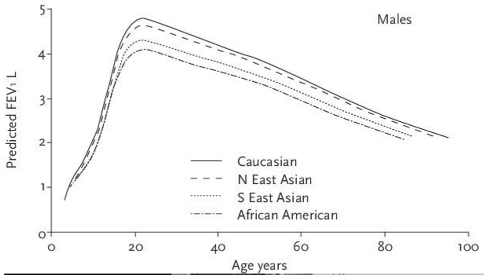

Decision of Age
- There is little difference between calculated age and given age: abs(Calc Age and Age) < 1.2 years. We choose Calc Age to enforce the principle of least information, but given the small difference we could also have used Age.

Decision for Predicted FEV1:
- A Predicted FEV1 below 2L and above 5L is unrealistic, according to the literature. The given measures in the clinical data: Predicted FEV1 and FEV1 Set As contain unrealistic values that go below 2L.
- Hence, we recaclulated the predicted FEV1 with the formula that the Royal Papworth Hospital's lung function test team uses. All measurements are within the 2-5L range.
- 85% of individuals have a difference between Predicted FEV1 and Calc Predicted FEV1 lower than 300mL.
- We choose to use the calculated predicted FEV1 and ignore any other information about predicted FEV1.

In [1]:
import patient_data
import pandas as pd
import biology as bio

from dateutil.relativedelta import relativedelta
import plotly.graph_objects as go


def move_column_next_to(df, col_name, taget_col_name):
    idx = df.columns.get_loc(taget_col_name)
    df.insert(idx + 1, col_name, df.pop(col_name))
    return df


In [2]:
df = patient_data.load(use_calc_age=False, use_calc_predicted_fev1=False)


** Loading patient data **

* Dropping unnecessary columns from patient data *
Columns filtered: ['ID', 'Study Date', 'DOB', 'Age', 'Sex', 'Height', 'Weight', 'Predicted FEV1', 'FEV1 Set As']
Columns dropped: {'Inconvenience Payment', 'Genetic Testing', 'Transplant Recipients', 'Remote Monitoring App User ID', 'Freezer Required', 'Informed Consent', 'Telemetric Measures', 'Date Consent Obtained', 'Sputum Samples', 'CFQR Quest Comp', 'Less Exacerbation', 'Study Number', 'GP Letter Sent', 'Comments', 'Hospital', 'Age 18 Years', 'Date Last PE Stop', 'Unable Informed Consent', 'Study Email', 'Date Last PE Start', 'Pulmonary Exacerbation', 'Unable Sputum Samples'}

* Correcting patient data *
ID 60: Corrected height 60 from 1.63 to 163.0
ID 66: Corrected height for ID 66 from 1.62 to 162.0

* Applying data sanity checks *
Warning - ID 206 has Predicted FEV1 (1.76) outside 2-5L range
Warning - ID 212 has Predicted FEV1 (1.81) outside 2-5L range
Warning - ID 214 has Predicted FEV1 (1.77) out

/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/tristan.trebaol/Desktop/PhD/Code/phd/src/data/patient_data.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Height.loc[df.ID == "60"] = tmp * 100


## Age vs Calc Age

In [43]:
def get_years_decimal_delta(start_date, end_date):
    return (
        relativedelta(end_date, start_date).years
        + relativedelta(end_date, start_date).months / 12
    )


df["Calc Age Exact"] = df.apply(
    lambda row: get_years_decimal_delta(row.DOB, row["Study Date"]), axis=1
)
df["Calc Age"] = df.apply(
    lambda row: round(get_years_decimal_delta(row.DOB, row["Study Date"])), axis=1
)
df["diff Age - Calc Age Exact"] = df.apply(
    lambda row: row.Age - row["Calc Age Exact"], axis=1
)
move_column_next_to(df, "diff Age - Calc Age Exact", "Age")
move_column_next_to(df, "Calc Age Exact", "Age")
move_column_next_to(df, "Calc Age", "Age")

df[abs(df["diff Age - Calc Age Exact"]) > 1]


,ID,Study Date,DOB,Age,Calc Age,Calc Age Exact,diff Age - Calc Age Exact,Sex,Height,Weight,Predicted FEV1,FEV1 Set As,Calc Predicted FEV1,Predicted FEV1 - Calc Predicted FEV1,Calc Predicted FEV1 (linear),Calc Predicted FEV1 (GLI),Calc Predicted FEV1 (GLI) - Calc Predicted FEV1 (linear)


## Calc Predicted FEV1 formula from Royal Papworth Hospital

In [44]:
# Use Calc Age instead of Age
df["Age"] = df["Calc Age"]

print(df.Age.describe())
print(df.Height.describe())
print(df.Weight.describe())

# Create data frame with age from 1 to 100
df_age = pd.DataFrame({"Age": range(1, 101)})

# Get 5th largest value of height
height_high = df.Height.nlargest(5).iloc[-1]

# Compute Predicted FEV1 based on Age, Height and Weight
pred_fev1_male_high = "Predicted FEV1 (male, height: {} cm)".format(height_high)
df_age[pred_fev1_male_high] = df_age.apply(
    lambda row: bio.calc_predicted_fev1(height_high, row.Age, "Male")["Predicted FEV1"],
    axis=1,
)

# Get 5th largest value of height
height_med = 170

# Compute Predicted FEV1 based on Age, Height and Weight
pred_fev1_male_med = "Predicted FEV1 (male, height: {} cm)".format(height_med)
df_age[pred_fev1_male_med] = df_age.apply(
    lambda row: bio.calc_predicted_fev1(height_med, row.Age, "Male")["Predicted FEV1"],
    axis=1,
)

# Get 5th smallest value of height
height_low = df.Height.nsmallest(5).iloc[-1]

# Compute Predicted FEV1 based on Age, Height and Weight
pred_fev1_male_low = "Predicted FEV1 (male, height: {} cm)".format(height_low)
df_age[pred_fev1_male_low] = df_age.apply(
    lambda row: bio.calc_predicted_fev1(height_low, row.Age, "Male")["Predicted FEV1"],
    axis=1,
)

# PLot Predicted FEV1
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df_age["Age"],
        y=df_age[pred_fev1_male_high],
        mode="markers+lines",
        name="height: {} cm".format(height_high),
    )
)
# Add line for predicted FEV1 based on height_low
fig.add_trace(
    go.Scatter(
        x=df_age["Age"],
        y=df_age[pred_fev1_male_med],
        mode="markers+lines",
        name="height: {} cm".format(height_med),
    )
)
fig.add_trace(
    go.Scatter(
        x=df_age["Age"],
        y=df_age[pred_fev1_male_low],
        mode="markers+lines",
        name="height: {} cm".format(height_low),
    )
)
fig.update_layout(
    xaxis_title="Age",
    yaxis_title="Predicted FEV1 (L) for a male",
)
fig.show()

count    147.000000
mean      31.544218
std        9.372235
min       18.000000
25%       24.000000
50%       30.000000
75%       37.000000
max       66.000000
Name: Age, dtype: float64
count    147.000000
mean     166.325034
std        9.356636
min      143.000000
25%      159.500000
50%      166.000000
75%      173.250000
max      189.000000
Name: Height, dtype: float64
count    147.000000
mean      62.969048
std       12.181396
min       34.300000
25%       54.200000
50%       61.600000
75%       70.100000
max      117.300000
Name: Weight, dtype: float64


## Calc Predicted FEV1 from formula from GLI

In [4]:
# Use Calc Age instead of Age
df["Age"] = df["Calc Age"]

# Create data frame with age from 1 to 100
df_age_lms = pd.DataFrame({"Age": range(3, 96)})


# Setup model
ref_sex = "Male"
coeffs = bio.load_LMS_coeffs(ref_sex)

# Get 5th largest value of height
ref_height_high = df.Height.nlargest(5).iloc[-1]
# Compute Predicted FEV1 based on Age, Height and Weight
pred_fev1_male_high = "Predicted FEV1 (male, height: {} cm)".format(ref_height_high)
df_age_lms[pred_fev1_male_high] = df_age_lms.apply(
    lambda row: bio.calc_LMS_predicted_FEV1(
        bio.load_LMS_spline_vals(row.Age, ref_sex),
        coeffs,
        ref_height_high,
        row.Age,
        ref_sex,
    )["Predicted FEV1"],
    axis=1,
)

ref_height_med = 170
# Compute Predicted FEV1 based on Age, Height and Weight
pred_fev1_male_med = "Predicted FEV1 (male, height: {} cm)".format(ref_height_med)
df_age_lms[pred_fev1_male_med] = df_age_lms.apply(
    lambda row: bio.calc_LMS_predicted_FEV1(
        bio.load_LMS_spline_vals(row.Age, ref_sex),
        coeffs,
        ref_height_med,
        row.Age,
        ref_sex,
    )["Predicted FEV1"],
    axis=1,
)

# Get 5th smallest value of height
ref_height_low = df.Height.nsmallest(5).iloc[-1]

# Compute Predicted FEV1 based on Age, Height and Weight
pred_fev1_male_low = "Predicted FEV1 (male, height: {} cm)".format(ref_height_low)
df_age_lms[pred_fev1_male_low] = df_age_lms.apply(
    lambda row: bio.calc_LMS_predicted_FEV1(
        bio.load_LMS_spline_vals(row.Age, ref_sex),
        coeffs,
        ref_height_low,
        row.Age,
        ref_sex,
    )["Predicted FEV1"],
    axis=1,
)

In [45]:
# Plot Predicted FEV1

# GLI
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df_age_lms["Age"],
        y=df_age_lms[pred_fev1_male_high],
        mode="markers+lines",
        name="Spline (GLI) - height: {} cm".format(ref_height_high),
    )
)
fig.add_trace(
    go.Scatter(
        x=df_age_lms["Age"],
        y=df_age_lms[pred_fev1_male_med],
        mode="markers+lines",
        name="Spline (GLI) - height: {} cm".format(ref_height_med),
    )
)
# fig.add_trace(
#     go.Scatter(
#         x=df_age_lms["Age"],
#         y=df_age_lms[pred_fev1_male_low],
#         mode="markers+lines",
#         name="GLI - height: {} cm".format(ref_height_low),
#     )
# )


# Papworth hospital
fig.add_trace(
    go.Scatter(
        x=df_age["Age"],
        y=df_age[pred_fev1_male_high],
        mode="markers+lines",
        name="Linear - height: {} cm".format(height_high),
    )
)
fig.add_trace(
    go.Scatter(
        x=df_age["Age"],
        y=df_age[pred_fev1_male_med],
        mode="markers+lines",
        name="Linear - height: {} cm".format(height_med),
    )
)
# fig.add_trace(
#     go.Scatter(
#         x=df_age["Age"],
#         y=df_age[pred_fev1_male_low],
#         mode="markers+lines",
#         name="Pap Hosp - height: {} cm".format(height_low),
#     )
# )
fig.update_layout(
    xaxis_title="Age",
    yaxis_title="Predicted FEV1 (L) for a male",
)
fig.show()


The linear model tends to underestimate the predicted FEV1 between 20 and 60 years old. The taller the individual, the bigger the difference (~150mL for 170cm, ~300mL for 184cm).

This means that the FEV1 % predicted has been overestimated.

## FEV1 Set As vs Predicted FEV1 vs Calc Predicted FEV1

In [5]:
# Use Calc Age instead of Age
df["Age"] = df["Calc Age"]

df["Calc Predicted FEV1"] = df.apply(
    lambda x: bio.calc_predicted_fev1(x.Height, x.Age, x.Sex), axis=1
)

# List idx where diff Predicted FEV1 and FEV1 Set As is > 0.1
diff_name = "Predicted FEV1 - FEV1 Set As"
df[diff_name] = df["Predicted FEV1"] - df["FEV1 Set As"]

# Sort df by Predicted FEV1 Calc (L)
df.sort_values(by=[diff_name], inplace=True)
# Use go.scatter to plot FEV1 Predicted in y with ID in x
fig = go.Figure(
    data=go.Scatter(
        x=df["ID"],
        y=df["Predicted FEV1"],
        name="Predicted FEV1",
        mode="markers",
        opacity=0.9,
    )
)
# Add the same with FEV1 Set As with name "FEV1 Set As"
fig.add_trace(
    go.Scatter(
        x=df["ID"], y=df["FEV1 Set As"], name="FEV1 Set As", mode="markers", opacity=0.9
    )
)
# Add the same with FEV1 Predicted Calc (L) with name "Predicted FEV1 Calc (L)"
fig.add_trace(
    go.Scatter(
        x=df["ID"],
        y=df["Calc Predicted FEV1"],
        name="Calc Predicted FEV1",
        mode="markers",
        opacity=0.9,
    )
)
fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
# Add red constant red lines for volume of 2L and 5L
fig.add_shape(
    type="line", x0=0, y0=2, x1=len(df), y1=2, line=dict(color="Black", width=1)
)
fig.add_shape(
    type="line", x0=0, y0=5, x1=len(df), y1=5, line=dict(color="Black", width=1)
)
# Set yaxis legend to Volume (L)
fig.update_yaxes(title_text="Volume (L)")
# Set xaxis legend to ID
fig.update_xaxes(title_text="ID")
# Reduce xaxis labels font size
fig.update_xaxes(tickfont_size=4)
fig.show()

df[df[diff_name].abs() > 0.1][
    [
        "ID",
        "Age",
        "Sex",
        "Height",
        "Weight",
        "Predicted FEV1",
        "FEV1 Set As",
        "Calc Predicted FEV1",
        diff_name,
    ]
].sort_values(by=[diff_name], ascending=False)


,ID,Age,Sex,Height,Weight,Predicted FEV1,FEV1 Set As,Calc Predicted FEV1,Predicted FEV1 - FEV1 Set As
112,152,36,Male,175.0,73.9,4.20,1.30,3.9910,2.90
124,172,25,Female,159.0,51.4,3.14,1.13,3.0555,2.01
113,153,36,Male,189.0,77.4,4.97,3.36,4.5930,1.61
107,151,28,Female,150.6,69.1,2.75,1.20,2.6487,1.55
115,169,23,Female,168.0,67.0,4.14,3.30,3.4610,0.84
56,142,29,Male,173.0,73.0,4.81,4.10,4.1080,0.71
120,170,22,Male,171.0,75.0,4.28,3.61,4.2250,0.67
125,173,37,Female,161.0,61.6,3.03,2.59,2.8345,0.44
31,93,31,Female,170.0,65.2,3.70,3.40,3.3400,0.30


## Predicted FEV vs Calc Predicted FEV1

In [6]:
# Use Calc Age instead of Age
df["Age"] = df["Calc Age"]

df["Calc Predicted FEV1"] = df.apply(
    lambda x: bio.calc_predicted_fev1(x.Height, x.Age, x.Sex)["Predicted FEV1"], axis=1
)

# List idx where diff Predicted FEV1 and FEV1 Set As is > 0.1
diff_name = "Predicted FEV1 - Calc Predicted FEV1"
df[diff_name] = df["Predicted FEV1"] - df["Calc Predicted FEV1"]

# Sort df by Predicted FEV1 Calc (L)
df.sort_values(by=[diff_name], inplace=True)
# df.sort_values(by=['Calc Predicted FEV1'], inplace=True)
# Use go.scatter to plot FEV1 Predicted in y with ID in x
fig = go.Figure(
    data=go.Scatter(
        x=df["ID"],
        y=df["Predicted FEV1"],
        name="Predicted FEV1",
        mode="markers",
        opacity=0.9,
    )
)
# Add the same with FEV1 Predicted Calc (L) with name "Predicted FEV1 Calc (L)"
fig.add_trace(
    go.Scatter(
        x=df["ID"],
        y=df["Calc Predicted FEV1"],
        name="Calc Predicted FEV1",
        mode="markers",
        opacity=0.9,
    )
)
fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
# Add red constant red lines for volume of 2L and 5L
fig.add_shape(
    type="line", x0=0, y0=2, x1=len(df), y1=2, line=dict(color="Black", width=1)
)
fig.add_shape(
    type="line", x0=0, y0=5, x1=len(df), y1=5, line=dict(color="Black", width=1)
)
# Set yaxis legend to Volume (L)
fig.update_yaxes(title_text="Volume (L)")
# Set xaxis legend to ID
fig.update_xaxes(title_text="ID")
fig.update_xaxes(tickfont_size=4)
fig.show()


print("Describe Calc Predicted FEV1:\n{}".format(df["Calc Predicted FEV1"].describe()))
print("Describe Predicted FEV1:\n{}".format(df["Predicted FEV1"].describe()))

threshold = 0.3
outliers = df[df[diff_name].abs() > threshold][
    [
        "ID",
        "Age",
        "Sex",
        "Height",
        "Weight",
        "Predicted FEV1",
        "Calc Predicted FEV1",
        diff_name,
    ]
].sort_values(by=[diff_name], ascending=False)

print(
    "Number of unique IDs: {}\nNumber of outliers: {}\nPercentage of values with diff > {}L: {}".format(
        len(df["ID"].unique()),
        len(outliers),
        threshold,
        100 * len(outliers) / len(df["ID"].unique()),
    )
)

outliers


Describe Calc Predicted FEV1:
count    147.000000
mean       3.435403
std        0.599381
min        2.141000
25%        2.983750
50%        3.353000
75%        3.908000
max        4.726000
Name: Calc Predicted FEV1, dtype: float64
Describe Predicted FEV1:
count    147.000000
mean       3.343946
std        0.744761
min        0.880000
25%        2.940000
50%        3.260000
75%        3.920000
max        4.970000
Name: Predicted FEV1, dtype: float64
Number of unique IDs: 147
Number of outliers: 23
Percentage of values with diff > 0.3L: 15.646258503401361


,ID,Age,Sex,Height,Weight,Predicted FEV1,Calc Predicted FEV1,Predicted FEV1 - Calc Predicted FEV1
56,142,29,Male,173.0,73.0,4.81,4.10800,0.70200
115,169,23,Female,168.0,67.0,4.14,3.46100,0.67900
110,196,33,Female,173.5,77.4,4.06,3.42825,0.63175
54,57,30,Female,167.7,70.2,3.80,3.27415,0.52585
113,153,36,Male,189.0,77.4,4.97,4.59300,0.37700
31,93,31,Female,170.0,65.2,3.70,3.34000,0.36000
134,178,21,Female,167.0,61.5,3.17,3.47150,-0.30150
79,208,29,Male,173.0,72.0,3.60,4.10800,-0.50800
73,61,25,Male,159.0,65.0,3.10,3.62200,-0.52200
91,143,29,Female,163.0,56.8,2.36,3.11350,-0.75350


# Calc predicted FEV1 from linear model vs from GLI

In [ ]:
# Use Calc Age instead of Age
df["Age"] = df["Calc Age"]

df["Calc Predicted FEV1 (linear)"] = df.apply(
    lambda x: bio.calc_predicted_fev1(x.Height, x.Age, x.Sex)["Predicted FEV1"], axis=1
)

df["Calc Predicted FEV1 (GLI)"] = df.apply(
    lambda row: bio.calc_LMS_predicted_FEV1(
        bio.load_LMS_spline_vals(row.Age, row.Sex),
        bio.load_LMS_coeffs(row.Sex),
        row.Height,
        row.Age,
        row.Sex,
    )["Predicted FEV1"],
    axis=1,
)

# List idx where diff Predicted FEV1 and FEV1 Set As is > 0.1
diff_name = "Calc Predicted FEV1 (GLI) - Calc Predicted FEV1 (linear)"
df[diff_name] = df["Calc Predicted FEV1 (GLI)"] - df["Calc Predicted FEV1 (linear)"]

In [41]:
# Plot

# Sort df by Predicted FEV1 Calc (L)
df.sort_values(by=[diff_name], inplace=True)

# df.sort_values(by=['Calc Predicted FEV1 (linear)'], inplace=True)
# Use go.scatter to plot FEV1 Predicted in y with ID in x
fig = go.Figure(
    data=go.Scatter(
        x=df["ID"],
        y=df["Calc Predicted FEV1 (GLI)"],
        name="Calc Predicted FEV1 (GLI)",
        mode="markers",
        opacity=0.9,
    )
)
# Add the same with FEV1 Predicted Calc (L) with name "Predicted FEV1 Calc (L)"
fig.add_trace(
    go.Scatter(
        x=df["ID"],
        y=df["Calc Predicted FEV1 (linear)"],
        name="Calc Predicted FEV1 (linear)",
        mode="markers",
        opacity=0.9,
    )
)
# Add clinical predicted FEV1
fig.add_trace(
  go.Scatter(
          x=df["ID"],
          y=df["Predicted FEV1"],
          name="Predicted FEV1 (clinical)",
          mode="markers",
          marker_symbol='cross-thin',
          # marker_color="black",
          marker_line_color="black",
          marker_line_width=1,
          opacity=0.9,
      )
)
fig.update_traces(marker=dict(size=5), selector=dict(mode="markers"))
# Add red constant red lines for volume of 2L and 5L
fig.add_shape(
    type="line", x0=0, y0=2, x1=len(df), y1=2, line=dict(color="Black", width=1)
)
fig.add_shape(
    type="line", x0=0, y0=5, x1=len(df), y1=5, line=dict(color="Black", width=1)
)
# Set yaxis legend to Volume (L)
fig.update_yaxes(title_text="Volume (L)")
# Set xaxis legend to ID
fig.update_xaxes(title_text="ID")
fig.update_xaxes(tickfont_size=4)
fig.show()


print(
    "Describe Calc Predicted FEV1 (linear):\n{}".format(
        df["Calc Predicted FEV1 (linear)"].describe()
    )
)
print("Describe Calc Predicted FEV1 (GLI):\n{}".format(df["Predicted FEV1"].describe()))

threshold = 0.3
outliers = df[df[diff_name].abs() > threshold][
    [
        "ID",
        "Age",
        "Sex",
        "Height",
        "Weight",
        "Calc Predicted FEV1 (GLI)",
        "Calc Predicted FEV1 (linear)",
        diff_name,
    ]
].sort_values(by=[diff_name], ascending=False)

print(
    "Number of unique IDs: {}\nNumber of outliers: {}\nPercentage of values with diff > {}L: {}".format(
        len(df["ID"].unique()),
        len(outliers),
        threshold,
        100 * len(outliers) / len(df["ID"].unique()),
    )
)

outliers

Describe Calc Predicted FEV1 (linear):
count    147.000000
mean       3.435403
std        0.599381
min        2.141000
25%        2.983750
50%        3.353000
75%        3.908000
max        4.726000
Name: Calc Predicted FEV1 (linear), dtype: float64
Describe Calc Predicted FEV1 (GLI):
count    147.000000
mean       3.343946
std        0.744761
min        0.880000
25%        2.940000
50%        3.260000
75%        3.920000
max        4.970000
Name: Predicted FEV1, dtype: float64
Number of unique IDs: 147
Number of outliers: 1
Percentage of values with diff > 0.3L: 0.6802721088435374


,ID,Age,Sex,Height,Weight,Calc Predicted FEV1 (GLI),Calc Predicted FEV1 (linear),Calc Predicted FEV1 (GLI) - Calc Predicted FEV1 (linear)
113,153,36,Male,189.0,77.4,4.964348,4.593,0.371348


In [42]:
# compute the avg diff between Calc Predicted FEV1 (GLI) and Calc Predicted FEV1 (linear) of the absolute value
df[diff_name].abs().mean()

0.14102241133557805

In [19]:
df[df[diff_name] > 0.26]

,ID,Study Date,DOB,Age,Calc Age,Calc Age Exact,diff Age - Calc Age Exact,Sex,Height,Weight,Predicted FEV1,FEV1 Set As,Calc Predicted FEV1,Predicted FEV1 - Calc Predicted FEV1,Calc Predicted FEV1 (linear),Calc Predicted FEV1 (GLI),Calc Predicted FEV1 (GLI) - Calc Predicted FEV1 (linear)
142,180,2016-10-28,1980-11-21,36,36,35.916667,0.083333,Female,183.0,69.9,4.00,4.00,3.7285,0.2715,3.7285,3.995370,0.266870
111,235,2016-08-09,1992-07-12,24,24,24.000000,0.000000,Male,184.0,80.9,4.70,4.70,4.7260,-0.0260,4.7260,5.015503,0.289503
65,63,2016-02-26,1971-05-10,45,45,44.750000,0.250000,Male,185.0,54.3,4.20,4.20,4.1600,0.0400,4.1600,4.454096,0.294096
66,133,2016-02-29,1976-12-13,39,39,39.166667,-0.166667,Male,184.0,79.2,4.29,4.30,4.2910,-0.0010,4.2910,4.588898,0.297898
44,54,2016-01-14,1980-01-07,36,36,36.000000,0.000000,Male,184.0,80.7,4.40,4.40,4.3780,0.0220,4.3780,4.677537,0.299537
113,153,2016-08-15,1980-12-14,36,36,35.666667,0.333333,Male,189.0,77.4,4.97,3.36,4.5930,0.3770,4.5930,4.964348,0.371348


In [18]:
df[df[diff_name] < 0]

,ID,Study Date,DOB,Age,Calc Age,Calc Age Exact,diff Age - Calc Age Exact,Sex,Height,Weight,Predicted FEV1,FEV1 Set As,Calc Predicted FEV1,Predicted FEV1 - Calc Predicted FEV1,Calc Predicted FEV1 (linear),Calc Predicted FEV1 (GLI),Calc Predicted FEV1 (GLI) - Calc Predicted FEV1 (linear)
33,107,2015-12-21,1997-11-12,18,18,18.083333,-0.083333,Male,175.0,57.8,4.31,4.3,4.51300,-0.20300,4.51300,4.393125,-0.119875
4,80,2015-08-10,1994-08-16,21,21,20.916667,1.083333,Male,159.0,66.2,3.62,3.6,3.73800,-0.11800,3.73800,3.643001,-0.094999
139,204,2016-10-24,1998-04-01,18,18,18.500000,-0.500000,Female,150.0,57.0,2.93,2.9,2.87500,0.05500,2.87500,2.800531,-0.074469
140,201,2016-10-26,1998-07-30,18,18,18.166667,-0.166667,Female,149.0,34.3,2.83,2.8,2.83550,-0.00550,2.83550,2.761077,-0.074423
128,199,2016-09-30,1998-03-15,18,18,18.500000,0.500000,Female,155.0,45.8,3.20,3.2,3.07250,0.12750,3.07250,3.002242,-0.070258
94,210,2016-07-07,1995-10-23,21,21,20.666667,0.333333,Male,163.0,70.0,2.78,2.8,3.91000,-1.13000,3.91000,3.849548,-0.060452
123,171,2016-09-26,1997-10-03,19,19,18.916667,0.083333,Female,150.0,57.0,2.80,2.8,2.85000,-0.05000,2.85000,2.807185,-0.042815
102,144,2016-07-22,1997-10-04,19,19,18.750000,0.250000,Female,155.0,41.3,3.01,3.0,3.04750,-0.03750,3.04750,3.009375,-0.038125
75,207,2016-04-06,1996-12-07,19,19,19.250000,0.750000,Female,157.5,50.3,2.32,2.3,3.14625,-0.82625,3.14625,3.113262,-0.032988
10,82,2015-09-25,1997-05-06,18,18,18.333333,0.666667,Female,167.0,96.0,3.37,3.4,3.54650,-0.17650,3.54650,3.516714,-0.029786
